In [1]:
import pandas as pd
import numpy as np
import requests 
import matplotlib.pyplot as plt
import datetime 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

from fbprophet import Prophet 
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


Importing plotly failed. Interactive plots will not work.


In [2]:
## Import and clean data (copied from Daniela's script)

r = requests.get("https://api-pc6dbtrtla-uc.a.run.app/API/timeseries/usa")
response_dict = r.json()
df = pd.DataFrame.from_dict(response_dict)
df = df.rename(columns={'Total Results as of Date': 'Date'})
df['Day'] = (np.array([i for i in range (len(df.Date))]).reshape(-1,1))+1
df['Date'] = pd.to_datetime(df['Date']).dt.date

df['NewCases_1'] = df['Cases'] - df['Cases'].shift(1)
df['NewCases_7'] = df['Cases'] - df['Cases'].shift(7)
df['NewCases_14'] = df['Cases'] - df['Cases'].shift(14)

df['NewDeaths_1'] = df['Deaths'] - df['Deaths'].shift(1)
df['NewDeaths_7'] = df['Deaths'] - df['Deaths'].shift(7)
df['NewDeaths_14'] = df['Deaths'] - df['Deaths'].shift(14)

df.tail(14)

,ISO3,Country,Date,Cases,Deaths,Recovered,Day,NewCases_1,NewCases_7,NewCases_14,NewDeaths_1,NewDeaths_7,NewDeaths_14
103,USA,US,2020-05-04,1180375.0,68922.0,187180.0,104,22335.0,192178.0,396049.0,1240.0,12703.0,26263.0
104,USA,US,2020-05-05,1204351.0,71064.0,189791.0,105,23976.0,191769.0,392486.0,2142.0,12709.0,25978.0
105,USA,US,2020-05-06,1229331.0,73455.0,189910.0,106,24980.0,189422.0,388980.0,2391.0,12488.0,26043.0
106,USA,US,2020-05-07,1257023.0,75662.0,195036.0,107,27692.0,187599.0,387853.0,2207.0,12666.0,25938.0
107,USA,US,2020-05-08,1283929.0,77180.0,198993.0,108,26906.0,180468.0,378571.0,1518.0,12237.0,25687.0
108,USA,US,2020-05-09,1309550.0,78795.0,212534.0,109,25621.0,177011.0,371396.0,1615.0,12426.0,25040.0
109,USA,US,2020-05-10,1329260.0,79526.0,216169.0,110,19710.0,171220.0,363475.0,731.0,11844.0,24645.0
110,USA,US,2020-05-11,1347881.0,80682.0,232733.0,111,18621.0,167506.0,359684.0,1156.0,11760.0,24463.0
111,USA,US,2020-05-12,1369376.0,82356.0,230287.0,112,21495.0,165025.0,356794.0,1674.0,11292.0,24001.0
112,USA,US,2020-05-13,1390406.0,84119.0,243430.0,113,21030.0,161075.0,350497.0,1763.0,10664.0,23152.0


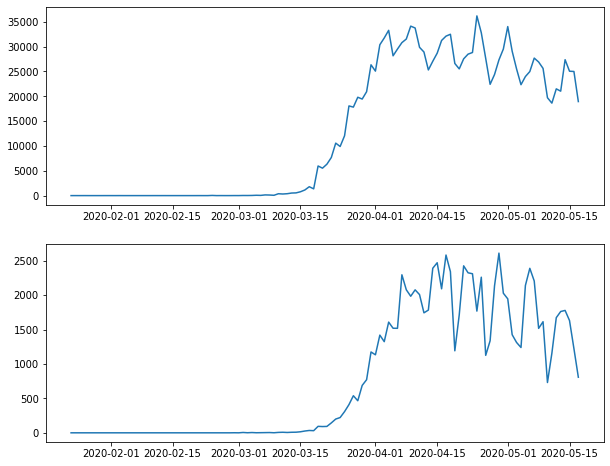

In [3]:
# Entire data from Jan 22th

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.plot(df["Date"], df["NewCases_1"])
ax2.plot(df["Date"], df["NewDeaths_1"])

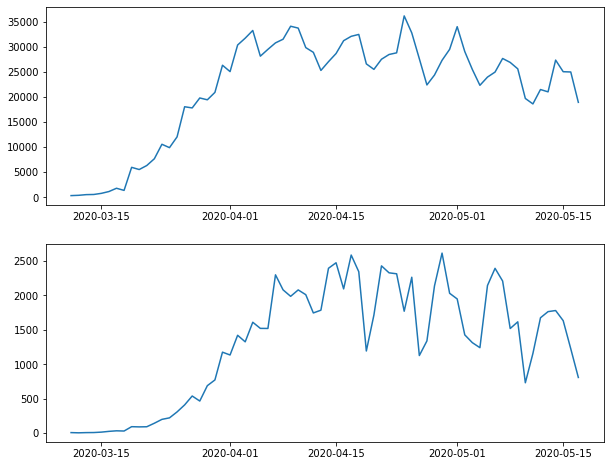

In [4]:
# Data since 3/11/20 (when WHO declared pandemic) 

df1 = df.loc[df["Date"]>=datetime.date(2020,3,11)]

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.plot(df1["Date"], df1["NewCases_1"])
ax2.plot(df1["Date"], df1["NewDeaths_1"])

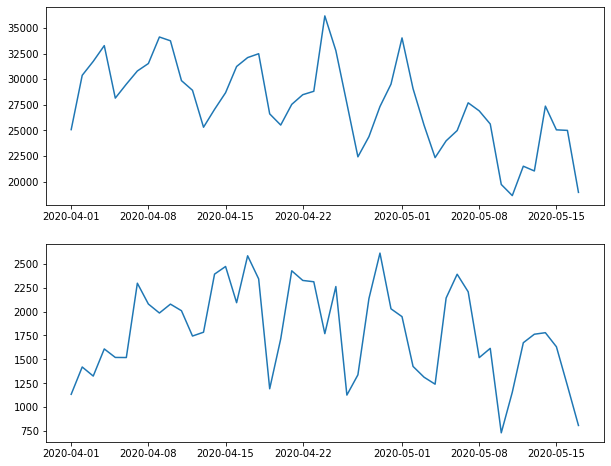

In [5]:
# Data since confirmed cases >= 20000 (since 4/1/20)

df2 = df.loc[df["Cases"]>=200_000]

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.plot(df2["Date"], df2["NewCases_1"])
ax2.plot(df2["Date"], df2["NewDeaths_1"])

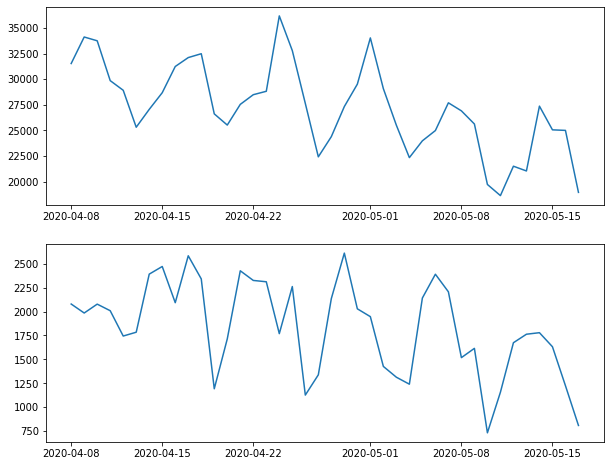

In [6]:
# Data since 4/8/20

df3 = df.loc[df["Date"]>=datetime.date(2020,4,8)]

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.plot(df3["Date"], df3["NewCases_1"])
ax2.plot(df3["Date"], df3["NewDeaths_1"])

In [7]:
df.shape

(117, 13)

In [8]:
df1.shape

(68, 13)

In [9]:
df2.shape

(47, 13)

In [10]:
df3.shape

(40, 13)

In [11]:
# Linear model predicting confirmed cases 

X = df2[["Day"]]
y = df2["NewCases_1"]

tscv = TimeSeriesSplit(n_splits=5)

lr = LinearRegression()
cross_validate(lr, X, y, cv=tscv, scoring="neg_mean_squared_error")["test_score"].mean()

-17021741.619070753

In [12]:
# Predict future confirmed cases

lr.fit(X, y)
lr.predict([[120]])

array([22760.67345051])

In [13]:
# Linear model predicting deaths

X = df3[["Day"]]
y = df3["NewDeaths_1"]

tscv = TimeSeriesSplit(n_splits=5)

lr = LinearRegression()
cross_validate(lr, X, y, cv=tscv, scoring="neg_mean_squared_error")["test_score"].mean()

-284187.53930409555

In [14]:
# Predict future deaths

lr.fit(X, y)
lr.predict([[120]])

array([1372.50365854])

In [15]:
### Prophet models ###

In [16]:
df_prophet1 = df1[["Date", "NewCases_1"]].rename(columns={"Date": "ds", "NewCases_1": "y"})
df_prophet2 = df2[["Date", "NewCases_1"]].rename(columns={"Date": "ds", "NewCases_1": "y"})

In [17]:
## Models for Confirmed Cases

# Model1: Starting date 3/11/20 
max_cases = df_prophet1["y"].max()
df_prophet1['cap'] = max_cases
df_prophet1

,ds,y,cap
49,2020-03-11,322.0,36188.0
50,2020-03-12,382.0,36188.0
51,2020-03-13,516.0,36188.0
52,2020-03-14,548.0,36188.0
53,2020-03-15,772.0,36188.0
...,...,...,...
112,2020-05-13,21030.0,36188.0
113,2020-05-14,27368.0,36188.0
114,2020-05-15,25050.0,36188.0
115,2020-05-16,24996.0,36188.0


In [18]:
prophet = Prophet(growth='logistic')
prophet.fit(df_prophet1)

future = prophet.make_future_dataframe(periods=10)
future['cap'] = max_cases

forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
68,2020-05-18,32691.126953,23317.462074,42728.075931
69,2020-05-19,34250.015699,24201.174323,43404.919204
70,2020-05-20,34012.058527,24471.627689,43301.157649
71,2020-05-21,36959.563041,28010.709851,46093.642418
72,2020-05-22,37646.075389,28453.593896,47122.383558
73,2020-05-23,36436.247513,27509.932648,45782.337081
74,2020-05-24,32965.928344,23363.348508,42708.785236
75,2020-05-25,33208.884379,23909.435206,42758.822490
76,2020-05-26,34736.665827,25493.718680,43853.114439
77,2020-05-27,34469.352379,25461.577503,43838.451575


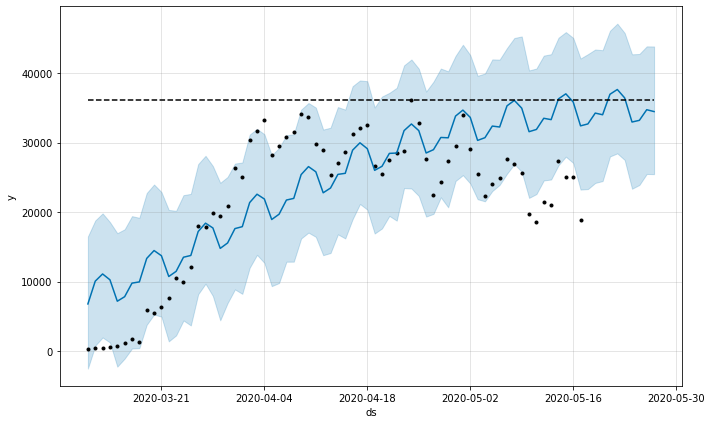

In [19]:
fig_forecast = prophet.plot(forecast)

In [20]:
df_cv = cross_validation(prophet, initial='50 days', period='4 days', horizon='7 days')

df_cv

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-02 00:00:00 and 2020-05-10 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-03,35150.875711,28930.456589,41369.293889,25501.0,2020-05-02
1,2020-05-04,33943.610036,27858.054266,39815.721756,22335.0,2020-05-02
2,2020-05-05,35063.918486,28778.491159,40999.341308,23976.0,2020-05-02
3,2020-05-06,35211.035044,29288.872824,41512.067473,24980.0,2020-05-02
4,2020-05-07,37564.533323,31152.487576,43951.814921,27692.0,2020-05-02
5,2020-05-08,38613.862695,32316.587004,44496.584060,26906.0,2020-05-02
6,2020-05-09,37075.227413,31336.279197,42953.852011,25621.0,2020-05-02
7,2020-05-07,38246.420912,31235.808800,44754.712723,27692.0,2020-05-06
8,2020-05-08,39309.657116,32840.275878,46488.729283,26906.0,2020-05-06
9,2020-05-09,37784.613505,30752.782322,44345.330514,25621.0,2020-05-06


In [21]:
df_p = performance_metrics(df_cv)

df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.480970e+08,12169.509976,11896.322339,0.530373,0.381136,0.0
1,2 days,1.599024e+08,12645.251275,12612.012210,0.541288,0.519750,0.0
2,3 days,1.593467e+08,12623.258395,12548.016123,0.540530,0.474752,0.0
3,4 days,1.469748e+08,12123.318193,11918.163632,0.518638,0.409569,0.0
4,5 days,1.665627e+08,12905.918801,12738.713410,0.563496,0.544973,0.0
5,6 days,1.518130e+08,12321.241218,12309.690693,0.509629,0.488749,0.0
6,7 days,1.810741e+08,13456.377852,13378.272665,0.629803,0.653074,0.0


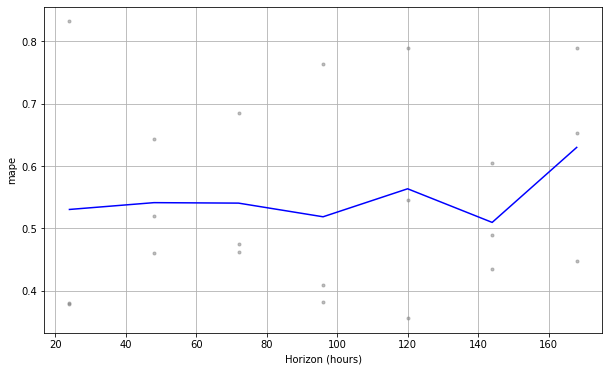

In [22]:
fig_test = plot_cross_validation_metric(df_cv, metric='mape')

In [23]:
# Model2: Starting date 4/1/20
df_prophet2 

,ds,y
70,2020-04-01,25070.0
71,2020-04-02,30380.0
72,2020-04-03,31745.0
73,2020-04-04,33283.0
74,2020-04-05,28152.0
75,2020-04-06,29515.0
76,2020-04-07,30804.0
77,2020-04-08,31533.0
78,2020-04-09,34126.0
79,2020-04-10,33755.0


In [24]:
prophet = Prophet()
prophet.fit(df_prophet2)

future = prophet.make_future_dataframe(periods=10)
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2020-04-01,29504.195387,27393.504691,31531.777211
1,2020-04-02,32743.894275,30682.644989,34928.139124
2,2020-04-03,34357.531124,32126.468996,36629.561886
3,2020-04-04,32812.644192,30727.893699,35080.358662
4,2020-04-05,28268.250714,26128.209004,30455.087980
5,2020-04-06,26415.689683,24127.451255,28553.593564
6,2020-04-07,28446.659036,26277.841082,30529.938864
7,2020-04-08,28945.638759,26985.461178,31059.932402
8,2020-04-09,32185.337635,29915.053440,34399.896202
9,2020-04-10,33798.974479,31798.226065,35757.117891


In [25]:
### MSE calculation for the last two weeks of data (for comparison with ARIMA model) ###

prophet_yhat = forecast[['ds', 'yhat']].copy()
prophet_yhat["ds"] = pd.to_datetime(prophet_yhat["ds"]).dt.date
prophet_yhat = prophet_yhat.loc[prophet_yhat["ds"]>=datetime.date(2020,5,4)]
prophet_yhat = prophet_yhat.loc[prophet_yhat["ds"]<=datetime.date(2020,5,17)]

df_prophet2["ds"] = pd.to_datetime(df_prophet2["ds"]).dt.date
df_prophet2 = df_prophet2.loc[df_prophet2["ds"]>=datetime.date(2020,5,4)]
df_prophet2 = df_prophet2.loc[df_prophet2["ds"]<=datetime.date(2020,5,17)]

mean_squared_error(df_prophet2["y"], prophet_yhat["yhat"])

1589110.591242851

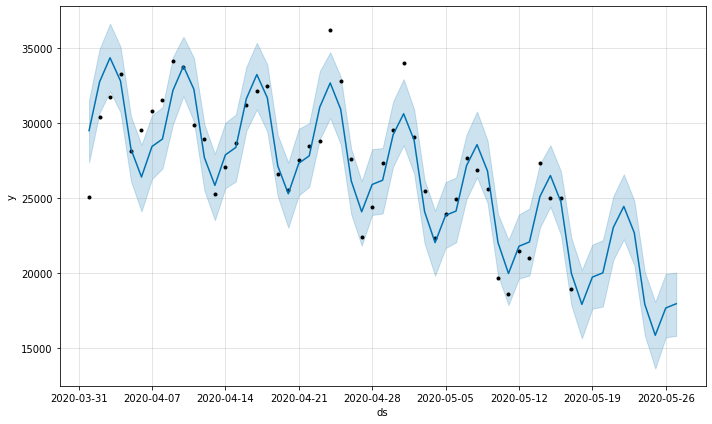

In [26]:
prophet_cases = prophet.plot(forecast)
prophet_cases.savefig("prophet_cases.png")

In [27]:
df_cv_cases = cross_validation(prophet, initial='30 days', period='4 days', horizon='7 days')

df_cv_cases

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-02 00:00:00 and 2020-05-10 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-03,26650.157168,24500.016474,29019.319432,25501.0,2020-05-02
1,2020-05-04,24510.771678,22289.107956,26809.781024,22335.0,2020-05-02
2,2020-05-05,26267.318427,23843.301303,28484.966028,23976.0,2020-05-02
3,2020-05-06,26805.606760,24382.950653,29004.756188,24980.0,2020-05-02
4,2020-05-07,29401.555166,27107.126230,31629.856101,27692.0,2020-05-02
5,2020-05-08,32151.622388,29833.591517,34390.372782,26906.0,2020-05-02
6,2020-05-09,30086.805700,27735.126765,32393.791301,25621.0,2020-05-02
7,2020-05-07,28791.041052,26613.283842,31101.911249,27692.0,2020-05-06
8,2020-05-08,31541.790234,29276.579621,33696.208927,26906.0,2020-05-06
9,2020-05-09,29475.151087,27165.363608,31672.303735,25621.0,2020-05-06


In [28]:
df_p_cases = performance_metrics(df_cv_cases)

df_p_cases

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,2.915654e+06,1707.528576,1580.630628,0.072890,0.045063,0.666667
1,2 days,9.284294e+06,3047.013984,2695.876590,0.109692,0.097415,0.666667
2,3 days,8.296604e+06,2880.382579,2777.659127,0.116672,0.104018,0.666667
3,4 days,1.251199e+07,3537.229600,3016.824935,0.138978,0.073083,0.666667
4,5 days,9.976390e+06,3158.542411,2964.314003,0.136234,0.112381,0.333333
5,6 days,1.289634e+07,3591.148119,3113.907702,0.126621,0.150164,0.333333
6,7 days,1.473299e+07,3838.357916,3726.258080,0.168758,0.174303,0.000000


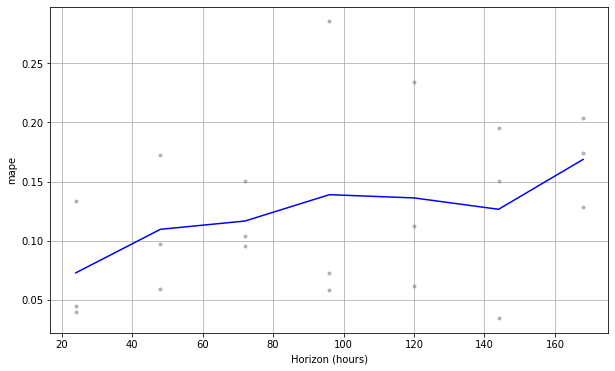

In [29]:
prophet_cases_test = plot_cross_validation_metric(df_cv_cases, metric='mape')
prophet_cases_test.savefig("prophet_cases_test.png")

In [30]:
# Model for Deaths
df_prophet3 = df3[["Date", "NewDeaths_1"]].rename(columns={"Date": "ds", "NewDeaths_1": "y"})
df_prophet3

,ds,y
77,2020-04-08,2079.0
78,2020-04-09,1985.0
79,2020-04-10,2078.0
80,2020-04-11,2009.0
81,2020-04-12,1744.0
82,2020-04-13,1784.0
83,2020-04-14,2392.0
84,2020-04-15,2472.0
85,2020-04-16,2093.0
86,2020-04-17,2584.0


In [31]:
prophet = Prophet()
prophet.fit(df_prophet3)

future = prophet.make_future_dataframe(periods=10)
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
40,2020-05-18,1063.253227,771.406662,1350.682119
41,2020-05-19,1771.049594,1501.959923,2067.214547
42,2020-05-20,1826.825798,1527.686051,2102.538348
43,2020-05-21,1620.496801,1346.961606,1905.638174
44,2020-05-22,1474.333873,1206.461978,1755.205177
45,2020-05-23,1366.004058,1087.441582,1648.066655
46,2020-05-24,705.346438,421.116406,986.972820
47,2020-05-25,935.537492,651.414759,1228.988993
48,2020-05-26,1643.333858,1364.790218,1943.476546
49,2020-05-27,1699.110063,1406.666528,1994.705252


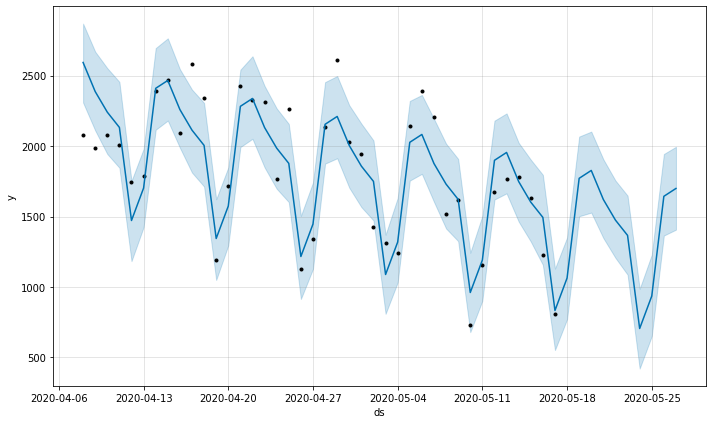

In [32]:
prophet_deaths = prophet.plot(forecast)
prophet_deaths.savefig("prophet_deaths.png")

In [33]:
df_cv_deaths = cross_validation(prophet, initial='23 days', period='4 days', horizon='7 days')

df_cv_deaths

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-02 00:00:00 and 2020-05-10 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-03,1205.117188,916.864678,1510.343256,1313.0,2020-05-02
1,2020-05-04,1463.114157,1149.231668,1773.608032,1240.0,2020-05-02
2,2020-05-05,2169.440528,1853.755354,2478.619934,2142.0,2020-05-02
3,2020-05-06,2186.152729,1889.018362,2491.365945,2391.0,2020-05-02
4,2020-05-07,1918.653852,1635.514937,2213.573737,2207.0,2020-05-02
5,2020-05-08,1908.403344,1635.734987,2215.779748,1518.0,2020-05-02
6,2020-05-09,1823.653340,1509.582021,2110.824469,1615.0,2020-05-02
7,2020-05-07,1929.381020,1633.093938,2214.235024,2207.0,2020-05-06
8,2020-05-08,1919.090475,1639.596405,2210.317322,1518.0,2020-05-06
9,2020-05-09,1834.311067,1543.893455,2105.339363,1615.0,2020-05-06


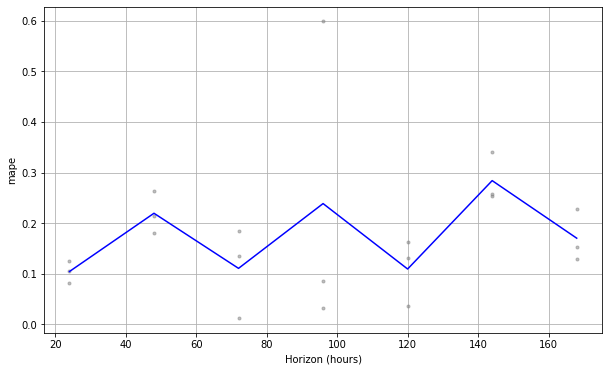

In [34]:
prophet_deaths_test = plot_cross_validation_metric(df_cv_deaths, metric='mape')
prophet_deaths_test.savefig("prophet_deaths_test.png")